In [1]:
import torch, time, sys
import autograd
import autograd.numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

EXPERIMENT_DIR = './experiment-single-force/'
sys.path.append(EXPERIMENT_DIR)

from data import get_dataset, get_trajectory, dynamics_fn, hamiltonian_fn, arrange_data, get_field
from nn_models import MLP, PSD
from symoden import SymODEN_R
from utils import L2_loss, from_pickle


In [2]:
DPI = 600
FORMAT = 'pdf'
LINE_SEGMENTS = 10
ARROW_SCALE = 40
ARROW_WIDTH = 6e-3
LINE_WIDTH = 1

def get_args():
    return {'input_dim': 2,
         'learn_rate': 1e-3,
         'nonlinearity': 'tanh',
         'name': 'pend',
         'gridsize': 10,
         'seed': 0,
         'save_dir': './{}'.format(EXPERIMENT_DIR),
         'fig_dir': './figures',
         'num_points': 5,
         'gpu': 0,
         'solver': 'dopri5',
         'rad': False,
         'gym': False}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

args = ObjectView(get_args())


 ## Load models

In [3]:
device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')
def get_model(args, baseline, structure, damping, num_points, gym=False):
    if structure == False and baseline == True:
        nn_model = MLP(args.input_dim, 600, args.input_dim, args.nonlinearity).to(device)    
        model = SymODEN_R(args.input_dim, H_net=nn_model, device=device, baseline=True)
    elif structure == False and baseline == False:
        H_net = MLP(args.input_dim, 400, 1, args.nonlinearity).to(device)
        g_net = MLP(int(args.input_dim/2), 200, int(args.input_dim/2)).to(device)
        model = SymODEN_R(args.input_dim, H_net=H_net, g_net=g_net, device=device, baseline=False)
    elif structure == True and baseline ==False:
        M_net = MLP(int(args.input_dim/2), 300, int(args.input_dim/2))
        V_net = MLP(int(args.input_dim/2), 50, 1).to(device)
        g_net = MLP(int(args.input_dim/2), 200, int(args.input_dim/2)).to(device)
        model = SymODEN_R(args.input_dim, M_net=M_net, V_net=V_net, g_net=g_net, device=device, baseline=False, structure=True).to(device)
    else:
        raise RuntimeError('argument *baseline* and *structure* cannot both be true')
    model_name = 'baseline_ode' if baseline else 'hnn_ode'
    struct = '-struct' if structure else ''
    rad = '-rad' if args.rad else ''
    path = '{}pend-{}{}-{}-p{}{}.tar'.format(args.save_dir, model_name, struct, args.solver, num_points, rad)
    model.load_state_dict(torch.load(path, map_location=device))
    path = '{}/pend-{}{}-{}-p{}-stats{}.pkl'.format(args.save_dir, model_name, struct, args.solver, num_points, rad)
    stats = from_pickle(path)
    return model, stats

base_ode_model, base_ode_stats = get_model(args, baseline=True, structure=False, damping=False, num_points=args.num_points, gym=args.gym)
symoden_ode_model, symoden_ode_stats = get_model(args, baseline=False, structure=False, damping=False, num_points=args.num_points, gym=args.gym)
symoden_ode_struct_model, symoden_ode_struct_stats = get_model(args, baseline=False, structure=True, damping=False, num_points=args.num_points, gym=args.gym)


 ## Final training loss

In [4]:
def get_model_parm_nums(model):
    total = sum([param.nelement() for param in model.parameters()])
    return total

print('Naive Baseline contains {} parameters'.format(get_model_parm_nums(base_ode_model)))
print('Final trajectory train loss {:.4e} +/- {:.4e}\nFinal trajectory test loss {:.4e} +/- {:.4e}'
.format(np.mean(base_ode_stats['traj_train_loss']), np.std(base_ode_stats['traj_train_loss']),
        np.mean(base_ode_stats['traj_test_loss']), np.std(base_ode_stats['traj_test_loss'])))
print('')
print('Unstructured SymODEN contains {} parameters'.format(get_model_parm_nums(symoden_ode_model)))
print('Final trajectory train loss {:.4e} +/- {:.4e}\nFinal trajectory test loss {:.4e} +/- {:.4e}'
.format(np.mean(symoden_ode_stats['traj_train_loss']), np.std(symoden_ode_stats['traj_train_loss']),
        np.mean(symoden_ode_stats['traj_test_loss']), np.std(symoden_ode_stats['traj_test_loss'])))
print('')
print('SymODEN contains {} parameters'.format(get_model_parm_nums(symoden_ode_struct_model)))
print('Final trajectory train loss {:.4e} +/- {:.4e}\nFinal trajectory test loss {:.4e} +/- {:.4e}'
.format(np.mean(symoden_ode_struct_stats['traj_train_loss']), np.std(symoden_ode_struct_stats['traj_train_loss']),
        np.mean(symoden_ode_struct_stats['traj_test_loss']), np.std(symoden_ode_struct_stats['traj_test_loss'])))


Naive Baseline contains 363602 parameters
Final trajectory train loss 9.1830e-01 +/- 6.3134e-01
Final trajectory test loss 8.8399e-01 +/- 6.0610e-01

Unstructured SymODEN contains 202802 parameters
Final trajectory train loss 1.1283e-01 +/- 9.3203e-02
Final trajectory test loss 1.0759e-01 +/- 7.6847e-02

SymODEN contains 134703 parameters
Final trajectory train loss 7.9634e-02 +/- 6.3834e-02
Final trajectory test loss 7.2518e-02 +/- 5.3607e-02


 ## Dataset to get prediction error

In [5]:
us = [0.0]
data = get_dataset(seed=args.seed, timesteps=40,
            save_dir=args.save_dir, us=us, samples=128) #us=np.linspace(-2.0, 2.0, 20)

pred_x, pred_t_eval = data['x'], data['t']


In [6]:
from torchdiffeq import odeint
def get_pred_loss(pred_x, pred_t_eval, model):
    pred_x = torch.tensor(pred_x, requires_grad=True, dtype=torch.float32).to(device) 
    pred_t_eval = torch.tensor(pred_t_eval, requires_grad=True, dtype=torch.float32).to(device)

    pred_loss = []
    for i in range(pred_x.shape[0]):
        pred_x_hat = odeint(model, pred_x[i, 0, :, :], pred_t_eval, method='rk4')            
        pred_loss.append((pred_x[i,:,:,:] - pred_x_hat)**2)
    
    pred_loss = torch.cat(pred_loss, dim=1)
    pred_loss_per_traj = torch.sum(pred_loss, dim=(0, 2))

    return pred_loss_per_traj.detach().cpu().numpy()

base_pred_loss = get_pred_loss(pred_x, pred_t_eval, base_ode_model)
symoden_pred_loss = get_pred_loss(pred_x, pred_t_eval, symoden_ode_model)
symoden_struct_pred_loss = get_pred_loss(pred_x, pred_t_eval, symoden_ode_struct_model)


In [7]:

print('Naive Baseline')
print('Prediction error {:.4e} +/- {:.4e}'
.format(np.mean(base_pred_loss), np.std(base_pred_loss)))
print('')
print('Unstructure SymODEN')
print('Prediction error {:.4e} +/- {:.4e}'
.format(np.mean(symoden_pred_loss), np.std(symoden_pred_loss)))
print('')
print('SymODEN')
print('Prediction error {:.4e} +/- {:.4e}'
.format(np.mean(symoden_struct_pred_loss), np.std(symoden_struct_pred_loss)))


Naive Baseline
Prediction error 1.9921e+01 +/- 1.7775e+01

Unstructure SymODEN
Prediction error 9.4631e+00 +/- 2.8442e+01

SymODEN
Prediction error 4.3100e+00 +/- 5.6322e+00


 ## Integrate to get trajectories

In [8]:
def integrate_model(model, t_span, y0, **kwargs):
    
    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,3).to(device)
        dx = model(0, x).detach().cpu().numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

t_span = [0,10]
y0 = np.asarray([1.8, 0])
u0 = 0.0
y0_u = np.asarray([1.8, 0, u0])
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], 1000), 'rtol': 1e-12}
base_ivp = integrate_model(base_ode_model, t_span, y0_u, **kwargs)
symoden_ivp = integrate_model(symoden_ode_model, t_span, y0_u, **kwargs)
symoden_struct_ivp = integrate_model(symoden_ode_struct_model, t_span, y0_u, **kwargs)



 ## Get vector field of different models

In [9]:
def get_vector_field(model, u=0, **kwargs):
    field = get_field(**kwargs)
    np_mesh_x = field['x']
    
    # run model
    mesh_x = torch.tensor( np_mesh_x, requires_grad=True, dtype=torch.float32).to(device)
    mesh_x_aug = torch.cat((mesh_x, u * torch.ones_like(mesh_x)[:,0].view(-1, 1)), dim=1)
    mesh_dx_aug = model(0, mesh_x_aug)
    mesh_dx = mesh_dx_aug[:, 0:2]
    return mesh_dx.detach().cpu().numpy()

# get their vector fields
R = 3.6
kwargs = {'xmin': -R, 'xmax': R, 'ymin': -R, 'ymax': R, 'gridsize': args.gridsize, 'u': u0}
field = get_field(**kwargs)
base_field = get_vector_field(base_ode_model, **kwargs)
symoden_field = get_vector_field(symoden_ode_model, **kwargs)
symoden_struct_field = get_vector_field(symoden_ode_struct_model, **kwargs)


 ## Plot learnt vector field

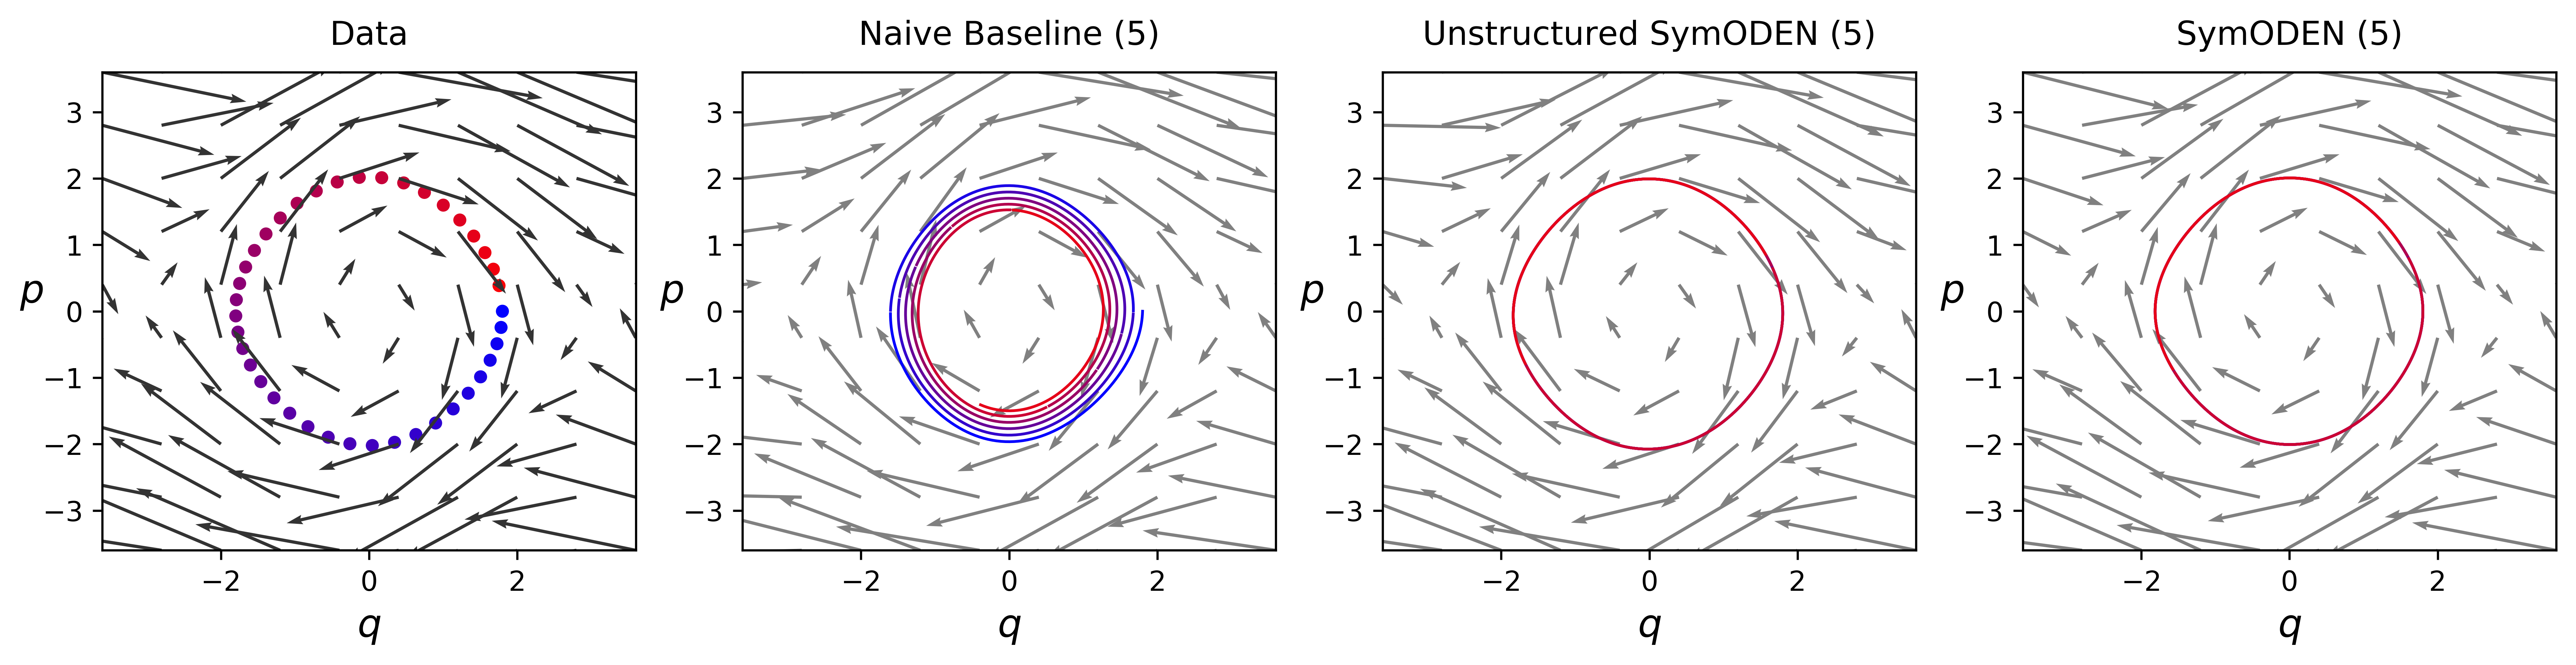

In [10]:
for _ in range(1):
    fig = plt.figure(figsize=(16, 3.2), dpi=DPI)

    plt.subplot(1, 4, 1)
    x, y, t = get_trajectory(timesteps=40, noise_std=0.0, y0=y0, radius=2.1, u=u0)
    N = len(x)
    point_colors = [(i/N, 0, 1-i/N) for i in range(N)]
    plt.scatter(x,y, s=14, label='data', c=point_colors)

    plt.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1],
            cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.2,.2,.2))  

    plt.xlabel("$q$", fontsize=14)
    plt.ylabel("$p$", rotation=0, fontsize=14)
    plt.title("Data", pad=10)
    plt.xlim(-R, R)
    plt.ylim(-R, R)

    plt.subplot(1, 4, 2)
    for i, l in enumerate(np.split(base_ivp['y'].T, LINE_SEGMENTS)):
        color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
        plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)

    plt.quiver(field['x'][:,0], field['x'][:,1], base_field[:,0], base_field[:,1],
            cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.5,.5,.5))

    plt.xlabel("$q$", fontsize=14)
    plt.ylabel("$p$", rotation=0, fontsize=14)
    plt.title("Naive Baseline ({})".format(args.num_points), pad=10)
    plt.xlim(-R, R)
    plt.ylim(-R, R)

    plt.subplot(1, 4, 3)
    for i, l in enumerate(np.split(symoden_ivp['y'].T, LINE_SEGMENTS)):
        color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
        plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)

    plt.quiver(field['x'][:,0], field['x'][:,1], symoden_field[:,0], symoden_field[:,1],
            cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.5,.5,.5))

    plt.xlabel("$q$", fontsize=14)
    plt.ylabel("$p$", rotation=0, fontsize=14)
    plt.title("Unstructured SymODEN ({})".format(args.num_points), pad=10)
    plt.xlim(-R, R)
    plt.ylim(-R, R)

    plt.subplot(1, 4, 4)
    for i, l in enumerate(np.split(symoden_struct_ivp['y'].T, LINE_SEGMENTS)):
        color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
        plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)

    plt.quiver(field['x'][:,0], field['x'][:,1], symoden_struct_field[:,0], symoden_struct_field[:,1],
            cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.5,.5,.5))

    plt.xlabel("$q$", fontsize=14)
    plt.ylabel("$p$", rotation=0, fontsize=14)
    plt.title("SymODEN ({})".format(args.num_points), pad=10)
    plt.xlim(-R, R)
    plt.ylim(-R, R)

# fig.savefig('{}/pend-single-force-p{}.{}'.format(args.fig_dir, args.num_points, FORMAT))


 ## Plot trajectory prediction

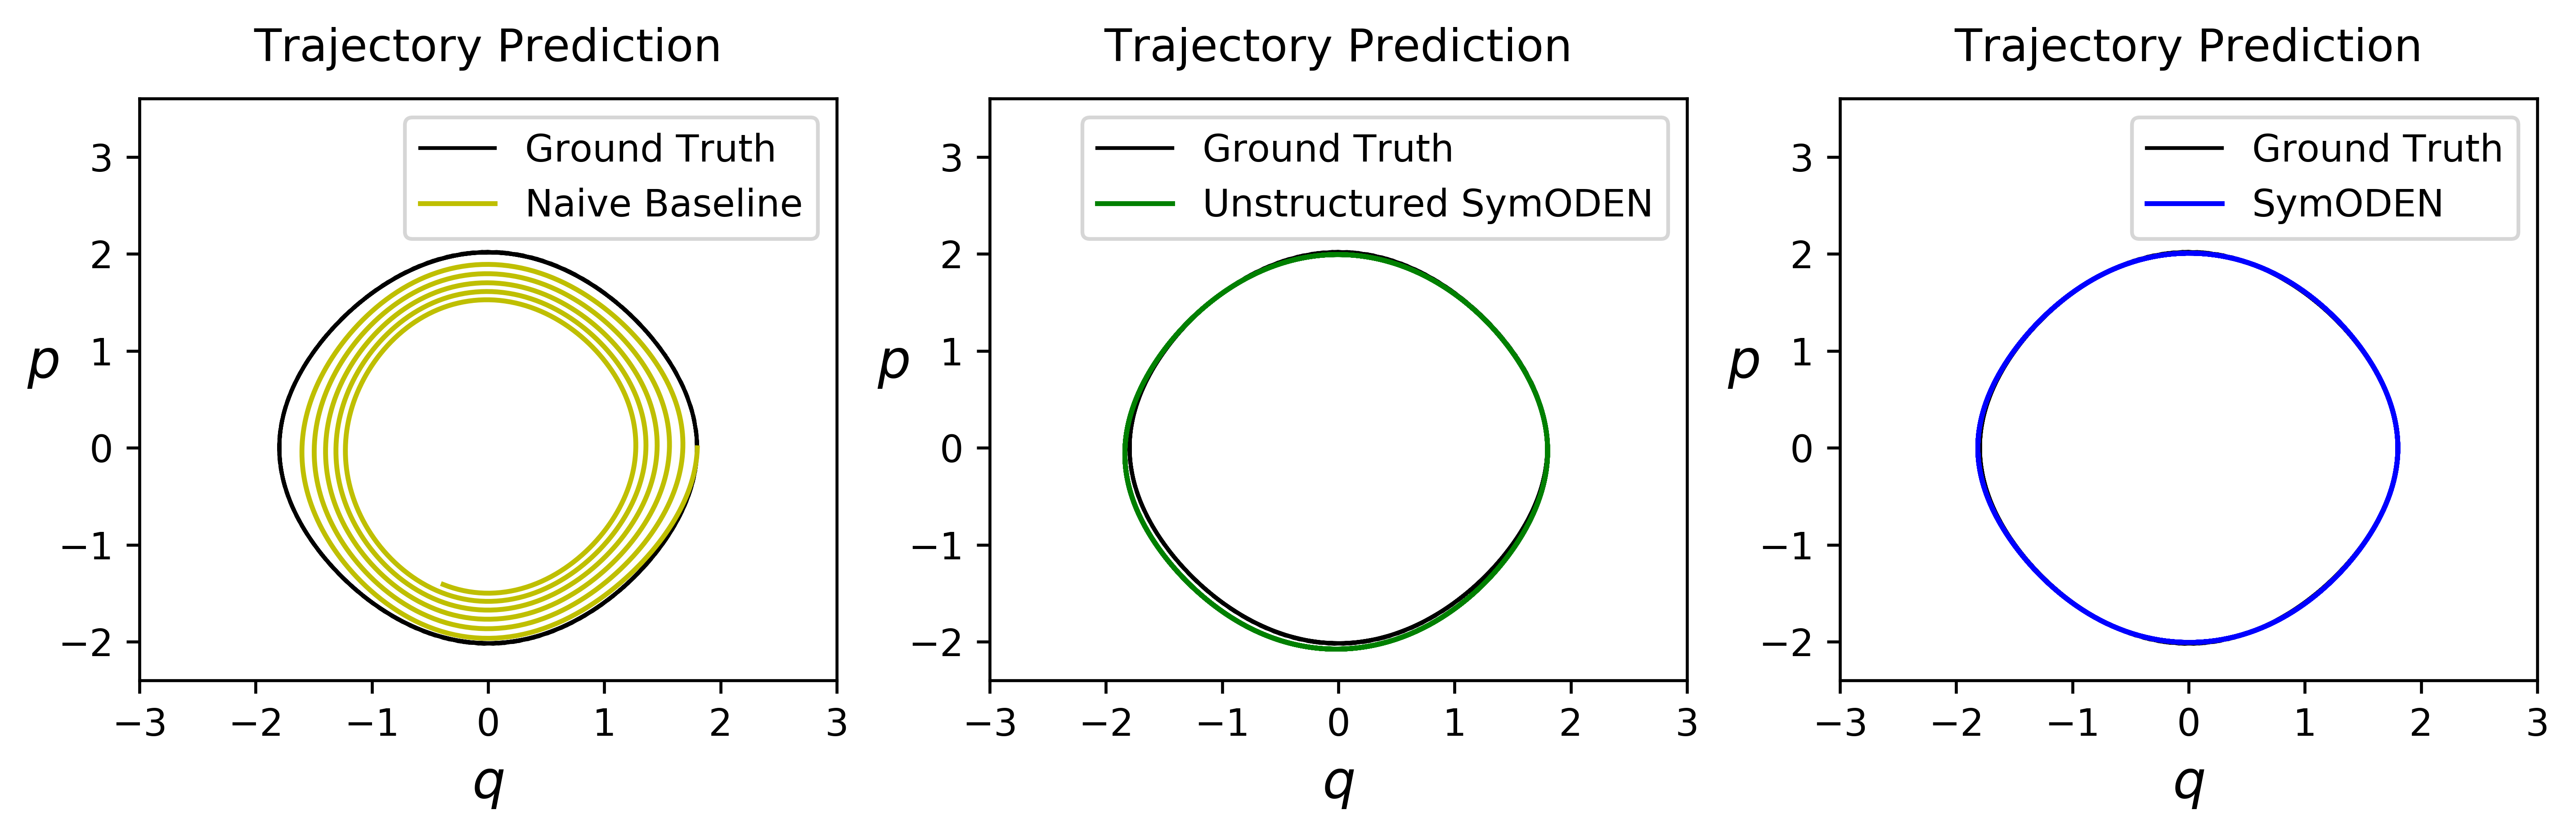

In [11]:
fig = plt.figure(figsize=(9.6, 3.2), dpi=DPI)
plt.subplot(1, 3, 1)

x, y, t = get_trajectory(timesteps=200, noise_std=0.0, y0=y0, u=u0)

plt.plot(x,y, label='Ground Truth', color='k', linewidth=1)
plt.plot(base_ivp['y'][0,:],base_ivp['y'][1,:], 'y', label='Naive Baseline', linewidth=1.3)

plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Trajectory Prediction", pad=10)
plt.xlim(-3, 3)
plt.ylim(-2.4, 3.6)
plt.legend(fontsize=10)

plt.subplot(1, 3, 2)

plt.plot(x,y, label='Ground Truth', color='k', linewidth=1)
plt.plot(symoden_ivp['y'][0,:],symoden_ivp['y'][1,:], 'g', label='Unstructured SymODEN', linewidth=1.3)

plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Trajectory Prediction", pad=10)
plt.xlim(-3, 3)
plt.ylim(-2.4, 3.6)
plt.legend(fontsize=10)

plt.subplot(1, 3, 3)

plt.plot(x,y, label='Ground Truth', color='k', linewidth=1)
plt.plot(symoden_struct_ivp['y'][0,:],symoden_struct_ivp['y'][1,:], 'b', label='SymODEN', linewidth=1.3)

plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Trajectory Prediction", pad=10)
plt.xlim(-3, 3)
plt.ylim(-2.4, 3.6)
plt.legend(fontsize=10)

plt.tight_layout()
# fig.savefig('{}/fig-single-traj.{}'.format(args.fig_dir, FORMAT))


 ## Plot learnt functions

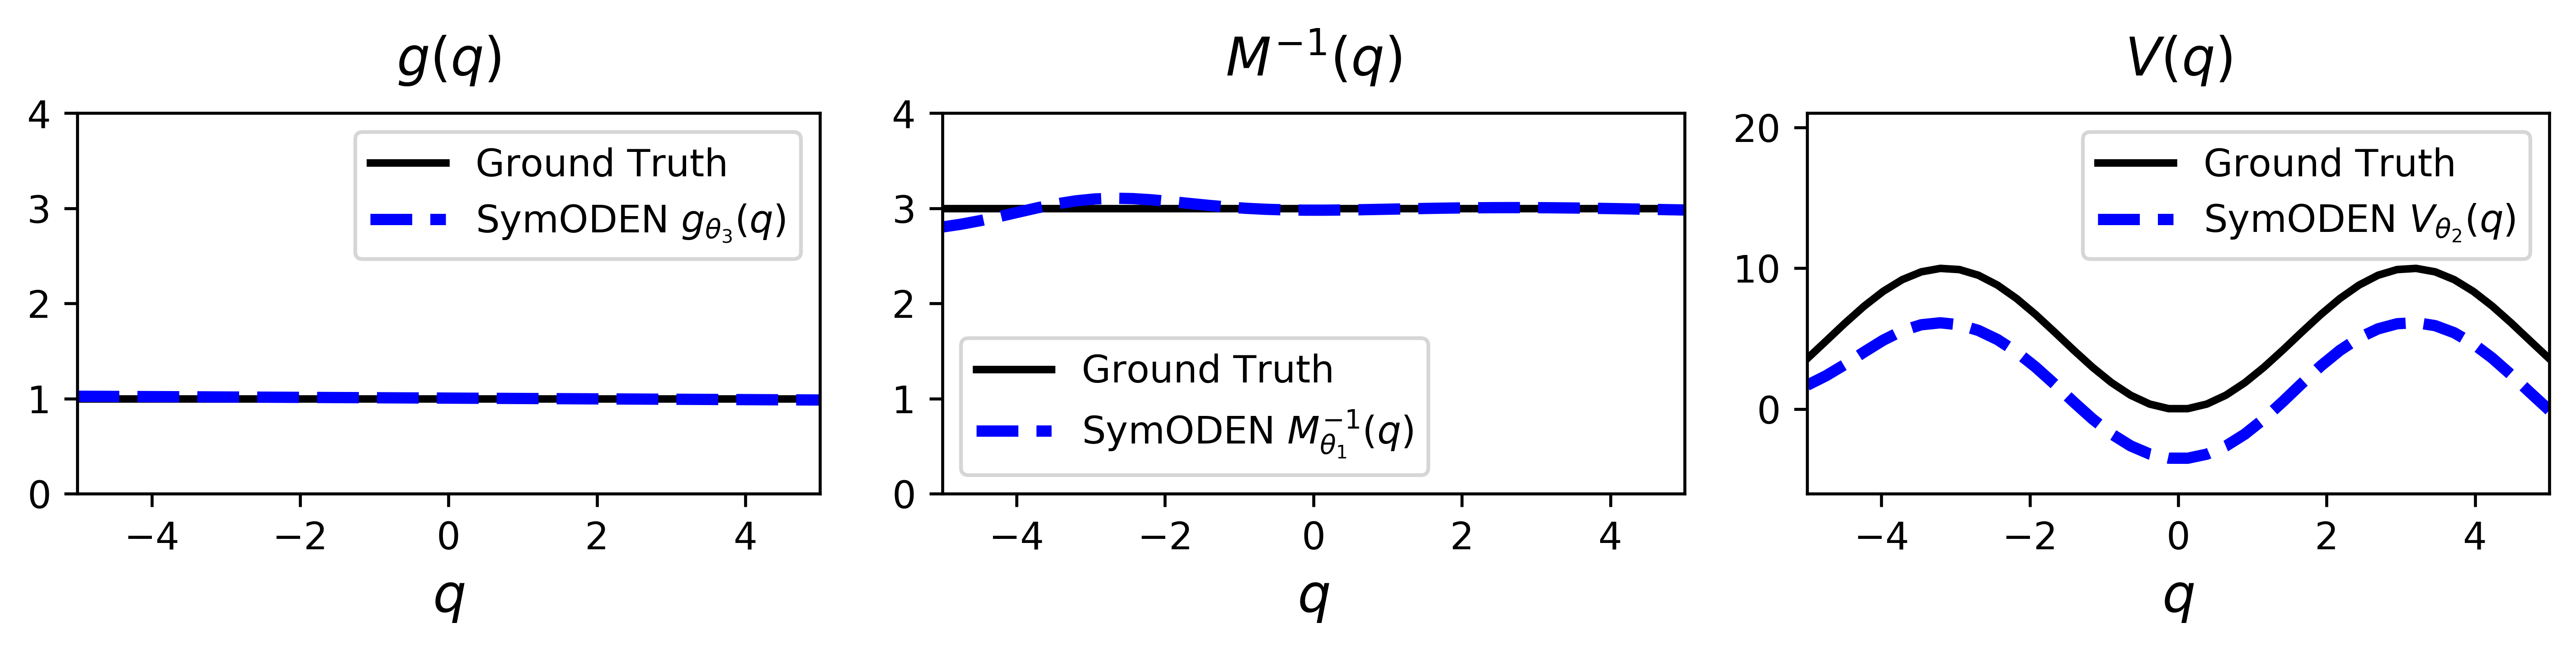

In [12]:
fig = plt.figure(figsize=(9.6, 2.5), dpi=DPI)
q = np.linspace(-5.0, 5.0, 40)
q_tensor = torch.tensor(q, dtype=torch.float32).view(40, 1).to(device)

plt.subplot(1, 3, 1)

g_q = symoden_ode_struct_model.g_net(q_tensor)
plt.plot(q, np.ones_like(q), label='Ground Truth', color='k', linewidth=2)
plt.plot(q, g_q.detach().cpu().numpy(), 'b--', linewidth=3, label=r'SymODEN $g_{\theta_3}(q)$')
plt.xlabel("$q$", fontsize=14)
# plt.ylabel("$g(q)$", rotation=0, fontsize=14)
plt.title("$g(q)$", pad=10, fontsize=14)
plt.xlim(-5, 5)
plt.ylim(0, 4)
plt.legend(fontsize=10)

M_q_inv = symoden_ode_struct_model.M_net(q_tensor)
plt.subplot(1, 3, 2)
plt.plot(q, 3 * np.ones_like(q), label='Ground Truth', color='k', linewidth=2)
plt.plot(q, M_q_inv.detach().cpu().numpy(), 'b--', linewidth=3, label=r'SymODEN $M^{-1}_{\theta_1}(q)$')
plt.xlabel("$q$", fontsize=14)
# plt.ylabel("$M^{-1}(q)$", rotation=0, fontsize=14)
plt.title("$M^{-1}(q)$", pad=10, fontsize=14)
plt.xlim(-5, 5)
plt.ylim(0, 4)
plt.legend(fontsize=10)

V_q = symoden_ode_struct_model.V_net(q_tensor)
plt.subplot(1, 3, 3)
plt.plot(q, 5.-5. * np.cos(q), label='Ground Truth', color='k', linewidth=2)
plt.plot(q, V_q.detach().cpu().numpy(), 'b--', linewidth=3, label=r'SymODEN $V_{\theta_2}(q)$')
plt.xlabel("$q$", fontsize=14)
# plt.ylabel("$V(q)$", rotation=0, fontsize=14)
plt.title("$V(q)$", pad=10, fontsize=14)
plt.xlim(-5, 5)
plt.ylim(-6, 21)
plt.legend(fontsize=10)
plt.tight_layout()
# fig.savefig('{}/fig-single-pend.{}'.format(args.fig_dir, FORMAT))
